# Contrastive Explanations Method (CEM) applied to Iris dataset

The Contrastive Explanation Method (CEM) can generate black box model explanations in terms of pertinent positives (PP) and pertinent negatives (PN). For PP, it finds what should be minimally and sufficiently present (e.g. important pixels in an image) to justify its classification. PN on the other hand identify what should be minimally and necessarily absent from the explained instance in order to maintain the original prediction.

The original paper where the algorithm is based on can be found on [arXiv](https://arxiv.org/pdf/1802.07623.pdf).

In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
import tensorflow as tf
from alibi.explainers import CEM

Using TensorFlow backend.


## Load and prepare Iris dataset

In [2]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

Scale data

In [3]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)

Define training and test set

In [4]:
idx = 145
x_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
x_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Define and train logistic regression model

In [5]:
def lr_model():
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

In [6]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0)
lr.save('iris_lr.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


## Generate contrastive explanation with pertinent negative

Explained instance:

In [7]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(lr.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(lr.predict(X)))

Prediction on instance to be explained: versicolor
Prediction probabilities for each class on the instance: [[0.01016025 0.52349985 0.4663398 ]]


CEM parameters:

In [8]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
classes = y_train.shape[1]
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 x_train.max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

Generate pertinent negative:

In [9]:
# init session before model definition
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(sess, lr, mode, shape, classes, kappa, beta, feature_range, 
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
          learning_rate_init=lr_init, clip=clip)
explanation = cem.explain(X, verbose=False)
sess.close()
K.clear_session()

In [10]:
print('Original instance: {}'.format(explanation['X']))
print('Predicted class: {}'.format(class_names[explanation['X_pred']]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: versicolor


In [11]:
print('Pertinent negative: {}'.format(explanation[mode]))
print('Predicted class: {}'.format(class_names[explanation[mode + '_pred']]))

Pertinent negative: [[ 0.59397644 -1.2552434   1.1424567   0.92230284]]
Predicted class: virginica


Store explanation to plot later on:

In [12]:
expl = {}
expl['PN'] = explanation[mode]
expl['PN_pred'] = explanation[mode + '_pred']

## Generate pertinent positive

In [13]:
mode = 'PP'

Generate pertinent positive:

In [14]:
# init session before model definition
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(sess, lr, mode, shape, classes, kappa, beta, feature_range, 
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
          learning_rate_init=lr_init, clip=clip)
explanation = cem.explain(X, verbose=False)
sess.close()
K.clear_session()


Iteration: 0; Const: 10.0
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

New best PP found!

Iteration: 100; Const: 10.0
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 200; Const: 10.0
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 300; Const: 10.0
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 400; Const: 10.0
Loss total: 0.000, loss attac


Iteration: 600; Const: 1.25
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 700; Const: 1.25
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 800; Const: 1.25
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 900; Const: 1.25
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 0; Const: 0.625
Loss total: 0.000, loss attack: 0.000
L2: 0.000,


Iteration: 200; Const: 0.078125
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 300; Const: 0.078125
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 400; Const: 0.078125
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 500; Const: 0.078125
Loss total: 0.000, loss attack: 0.000
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.56, max non target proba: 0.24
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000

Iteration: 600; Const: 0.078125
Loss total: 0.000, loss att

In [15]:
print('Pertinent positive: {}'.format(explanation[mode]))
print('Predicted class: {}'.format(class_names[explanation[mode + '_pred']]))

Pertinent positive: [[-7.44469730e-09 -3.47054341e-08  2.67991149e-08 -4.21282409e-09]]
Predicted class: versicolor


In [16]:
expl['PP'] = explanation[mode]
expl['PP_pred'] = explanation[mode + '_pred']

## Visualize PN and PP

Let's visualize the generated explanations to check if the perturbed instances make sense.

Create dataframe from standardized data:

In [17]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

Highlight explained instance and add pertinent negative and positive to the dataset:

In [18]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation['X'], columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation['X_pred']]
df = df.append([pn, pp, orig_inst], ignore_index=True)

Pair plots between the features show that the pertinent negative is pushed from the original instance (versicolor) into the virginica distribution while the pertinent positive moved away from the virginica distribution. Note that the CEM explainer did not have direct access to the training data but still made a meaningful perturbation.

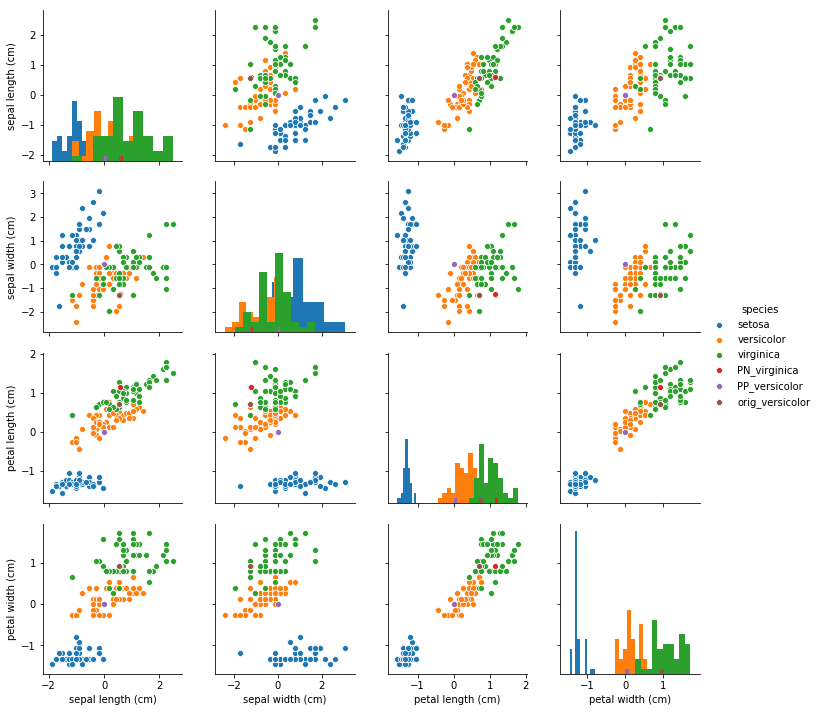

In [19]:
fig = sns.pairplot(df, hue='species', diag_kind='hist');

## Use numerical gradients in CEM

If we do not have access to the Keras or TensorFlow model weights, we can use numerical gradients for the first term in the loss function that needs to be minimized (eq. 1 and 4 in paper).

CEM parameters:

In [20]:
mode = 'PN'

If numerical gradients are used to compute dL/dx = dL/dp * dp/dx with L = loss function; p = predict function and x the parameter to optimize, then the tuple *eps* can be used to define the perturbation used to compute the derivatives. *eps[0]* is used to calculate dL/dp and *eps[1]* is used for dp/dx. *eps[0]* and *eps[1]* can be a combination of float values or numpy arrays. For *eps[0]*, the array dimension should be *(1 x nb of prediction categories)* and for *eps[1]* it should be *(1 x nb of features)*.

In [21]:
eps0 = np.array([[1e-2, 1e-2, 1e-2]])  # 3 prediction categories, equivalent to 1e-2
eps1 = np.array([[1e-2, 1e-2, 1e-2, 1e-2]])  # 4 features, also equivalent to 1e-2
eps = (eps0, eps1)

For complex models with a high number of parameters and a high dimensional feature space (e.g. Inception on ImageNet), evaluating numerical gradients can be expensive as they involve multiple prediction calls for each perturbed instance. The *update_num_grad* parameter allows you to set a batch size on which to evaluate the numerical gradients, drastically reducing the number of prediction calls required.  

In [22]:
update_num_grad = 1 

Generate pertinent negative:

In [23]:
# init session before model definition
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

# define model
lr = load_model('iris_lr.h5')
predict_fn = lambda x: lr.predict(x)  # only pass the predict fn which takes numpy arrays to CEM
                                      # explainer can no longer minimize wrt model weights

# initialize CEM explainer and explain instance
cem = CEM(sess, predict_fn, mode, shape, classes, kappa, beta, feature_range, 
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
          learning_rate_init=lr_init, clip=clip)
explanation = cem.explain(X, verbose=False)
sess.close()
K.clear_session()


Iteration: 0; Const: 10.0
Loss total: 2.572, loss attack: 2.572
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

Iteration: 100; Const: 10.0
Loss total: 2.572, loss attack: 2.572
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: -8.143/-2.871
Gradient numerical mean/abs mean: -4.958/4.958

Iteration: 200; Const: 10.0
Loss total: 2.572, loss attack: 2.572
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: -8.143/-2.871
Gradient numerical mean/abs mean: -4.958/4.958

Iteration: 300; Const: 


Iteration: 500; Const: 55.0
Loss total: 0.369, loss attack: 0.000
L2: 0.313, L1: 0.559, loss AE: 0.000
Target proba: 0.38, max non target proba: 0.62
Gradient graph min/max: 0.017/1.337
Gradient graph mean/abs mean: 0.406/0.406
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

Iteration: 600; Const: 55.0
Loss total: 0.320, loss attack: 0.000
L2: 0.259, L1: 0.609, loss AE: 0.000
Target proba: 0.38, max non target proba: 0.62
Gradient graph min/max: -0.000/0.649
Gradient graph mean/abs mean: 0.162/0.162
Gradient numerical attack min/max: -44.040/-15.458
Gradient numerical mean/abs mean: -26.753/26.753

Iteration: 700; Const: 55.0
Loss total: 2.881, loss attack: 2.697
L2: 0.146, L1: 0.382, loss AE: 0.000
Target proba: 0.42, max non target proba: 0.57
Gradient graph min/max: -0.000/0.974
Gradient graph mean/abs mean: 0.244/0.244
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

Iteration: 800; Const: 5


Iteration: 100; Const: 15.625
Loss total: 0.320, loss attack: 0.055
L2: 0.218, L1: 0.467, loss AE: 0.000
Target proba: 0.40, max non target proba: 0.60
Gradient graph min/max: -0.000/0.915
Gradient graph mean/abs mean: 0.229/0.229
Gradient numerical attack min/max: -12.471/-4.377
Gradient numerical mean/abs mean: -7.576/7.576

Iteration: 200; Const: 15.625
Loss total: 1.151, loss attack: 0.989
L2: 0.126, L1: 0.355, loss AE: 0.000
Target proba: 0.43, max non target proba: 0.57
Gradient graph min/max: -0.000/0.696
Gradient graph mean/abs mean: 0.174/0.174
Gradient numerical attack min/max: -12.687/-4.456
Gradient numerical mean/abs mean: -7.708/7.708

Iteration: 300; Const: 15.625
Loss total: 0.894, loss attack: 0.703
L2: 0.152, L1: 0.389, loss AE: 0.000
Target proba: 0.42, max non target proba: 0.58
Gradient graph min/max: -0.000/0.781
Gradient graph mean/abs mean: 0.195/0.195
Gradient numerical attack min/max: -12.598/-4.424
Gradient numerical mean/abs mean: -7.653/7.653

Iteration: 4


Iteration: 600; Const: 14.21875
Loss total: 3.656, loss attack: 3.656
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: -11.578/-4.082
Gradient numerical mean/abs mean: -7.050/7.050

Iteration: 700; Const: 14.21875
Loss total: 3.656, loss attack: 3.656
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: -11.578/-4.082
Gradient numerical mean/abs mean: -7.050/7.050

Iteration: 800; Const: 14.21875
Loss total: 3.656, loss attack: 3.656
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.52, max non target proba: 0.47
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: -11.578/-4.082
Gradient numerical mean/abs mean: -7.050/7.050

Ite

In [24]:
print('Original instance: {}'.format(explanation['X']))
print('Predicted class: {}'.format(class_names[explanation['X_pred']]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: versicolor


In [25]:
print('Pertinent negative: {}'.format(explanation[mode]))
print('Predicted class: {}'.format(class_names[explanation[mode + '_pred']]))

Pertinent negative: [[ 0.6635679  -1.2023996   1.0828744   0.92230284]]
Predicted class: virginica


Clean up:

In [3]:
os.remove('iris_lr.h5')